In [1]:
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torchsummary import summary
#from torchvision.models import resnet18
from b2aiprep.dataset import VBAIDataset
from b2aiprep.process import Audio, specgram, plot_spectrogram
import IPython.display as Ipd

2024-07-01 13:28:42.050319: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-01 13:28:48.347214: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Bridge2AI dataset

In [2]:
dataset = VBAIDataset('./bids_with_sensitive_recordings')


### Dataset split
- 80% for training
- 10% for validation
- 10% for testing

In [3]:
participant_df = dataset.load_and_pivot_questionnaire('participant')
all_identities = sorted(participant_df['record_id'].to_numpy().tolist())

N = len(all_identities)

train_identities = set(all_identities[:int(0.8*N)])
val_identities = set(all_identities[int(0.8*N):int(0.9*N)])
test_identities = set(all_identities[int(0.9*N):])

print('train:', len(train_identities))
print('val:', len(val_identities))
print('test:', len(test_identities))

train: 142
val: 18
test: 18


### Create PyTorch dataset of prolonged vowel audios with age and airway stenosis labels

In [4]:
qs = dataset.load_questionnaires('recordingschema')
q_dfs = []
for i, questionnaire in enumerate(qs):
    df = dataset.questionnaire_to_dataframe(questionnaire)
    df['dataframe_number'] = i
    q_dfs.append(df)
    i += 1
recordingschema_df = pd.concat(q_dfs)
recordingschema_df = pd.pivot(recordingschema_df, index='dataframe_number', columns='linkId', values='valueString')

person_session_pairs = recordingschema_df[['record_id', 'recording_session_id']].to_numpy().astype(str)
person_session_pairs = np.unique(person_session_pairs, axis=0).tolist()

print('Found {} person/session pairs'.format(len(person_session_pairs)))

Found 204 person/session pairs


In [8]:
class MySpecgramDataset(torch.utils.data.Dataset):
	def __init__(self, identities, dataset, person_session_pairs, segment_size=3):
		self.segment_size = segment_size
		
		# get age and airway stenosis classification for all subjects
		participant_df = dataset.load_and_pivot_questionnaire('participant')
		age_df = participant_df[['record_id', 'age']].to_numpy()
		airway_stenosis_df = participant_df[['record_id', 'airway_stenosis']].to_numpy()
        
		age_dict = {}
		for person_id, age in age_df:
			age_dict[str(person_id)] = float(age)
		airway_stenosis_dict = {}
		for person_id, airway_stenosis in airway_stenosis_df:
			airway_stenosis_dict[str(person_id)] = float(airway_stenosis)

		# get all prolonged vowel audios
		self.audio_files = []
		self.age = []
		self.airway_stenosis = []
        
		for person_id, session_id in person_session_pairs:
			if person_id not in identities:
				continue
			vowel_audios = [str(x) for x in dataset.find_audio(person_id, session_id) if str(x).endswith('-Prolonged-vowel.wav')]
			self.audio_files += vowel_audios
			self.age += [age_dict[person_id]]*len(vowel_audios)
			self.airway_stenosis += [airway_stenosis_dict[person_id]]*len(vowel_audios)

	def __len__(self):
		return len(self.audio_files)

	def __getitem__(self, idx):
		audio = Audio.from_file(self.audio_files[idx])
		audio = audio.to_16khz()
		# get middle K seconds if audio is too long, pad with zeros if it is too short
		if audio.signal.size(0) > self.segment_size*16000:
			d = (audio.signal.size(0)-self.segment_size*16000)//2
			audio.signal = audio.signal[d:d+self.segment_size*16000]
		else:
			audio.signal = torch.nn.functional.pad(audio.signal, (0,self.segment_size*16000-audio.signal.size(0)), mode='constant', value=0)

		win_length = 30
		hop_length = 10
		nfft = 512
		features_specgram = specgram(audio, win_length=win_length, hop_length=hop_length, n_fft=nfft)
		features_specgram = 10.0 * torch.log10(torch.maximum(features_specgram, torch.full(features_specgram.size(), fill_value=1e-10)))

		features_specgram = torch.nn.functional.interpolate(features_specgram.unsqueeze(0).unsqueeze(0), size=(256, 256), mode='bilinear', align_corners=False).squeeze(0).squeeze(0)

		return {'signal': features_specgram, 'age': self.age[idx], 'airway_stenosis': self.airway_stenosis[idx]}

tensor([93., 79., 69., 43., 33., 58., 23., 68.], dtype=torch.float64) tensor([0., 0., 0., 1., 0., 1., 0., 0.], dtype=torch.float64)
image shape:  torch.Size([256, 256])
Batch shape:  torch.Size([8, 256, 256])


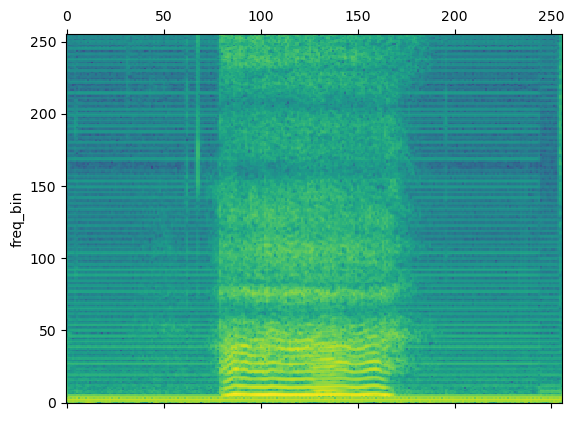

In [42]:
train_dataset = MySpecgramDataset(train_identities, dataset, person_session_pairs)
val_dataset = MySpecgramDataset(val_identities, dataset, person_session_pairs)
test_dataset = MySpecgramDataset(test_identities, dataset, person_session_pairs)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False)

for batch in train_dataloader:
	print(batch['age'], batch['airway_stenosis'])
	print("image shape: ", batch['signal'][0].T.shape)
	print("Batch shape: ", batch['signal'].shape)
	plot_spectrogram(batch['signal'][0].T)
	break

### Transformer Model

In [18]:
import torch
from torch import nn

from einops import rearrange, repeat
from einops.layers.torch import Rearrange

# helpers

def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# classes

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.norm = nn.LayerNorm(dim)

        self.attend = nn.Softmax(dim = -1)
        self.dropout = nn.Dropout(dropout)

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        dots = torch.matmul(q, k.transpose(-1, -2)) * self.scale

        attn = self.attend(dots)
        attn = self.dropout(attn)

        out = torch.matmul(attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout),
                FeedForward(dim, mlp_dim, dropout = dropout)
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = channels * patch_height * patch_width
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            nn.LayerNorm(patch_dim),
            nn.Linear(patch_dim, dim),
            nn.LayerNorm(dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity()

        self.mlp_head = nn.Linear(dim, num_classes)

    def forward(self, img):
        x = self.to_patch_embedding(img)
        b, n, _ = x.shape

        cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
        x = torch.cat((cls_tokens, x), dim=1)
        x += self.pos_embedding[:, :(n + 1)]
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        x = self.to_latent(x)
        return self.mlp_head(x)

In [38]:
model = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 2,
    dim = 1024,
    depth = 6,
    heads = 16,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)


### Training

In [41]:
def eval(model, dataloader):
	model.eval()
	acc = 0
	for batch in dataloader:
		with torch.no_grad():
			outputs = torch.mean(torch.nn.functional.sigmoid(model(batch['signal'])),dim=1).squeeze(1)
		for i in range(len(batch['signal'])):
			if outputs[i].item() > 0.5:
				acc += batch['airway_stenosis'][i]
			else:
				acc += 1.0-batch['airway_stenosis'][i]
	return acc/len(dataloader.dataset)	

num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-5)

best_val_acc = 0
for epoch in range(num_epochs):
	model.train()
	
	closs = []
	for batch in train_dataloader:
		optimizer.zero_grad()

		signal = batch['signal']
		
		fff= model(signal)

		outputs = torch.mean(torch.nn.functional.sigmoid(fff),dim=1).squeeze(1)
		loss = torch.nn.functional.binary_cross_entropy(outputs, batch['airway_stenosis'].float())
		closs += [loss.item()]*len(batch['signal'])
		loss.backward()
		optimizer.step()

	val_acc = eval(model, val_dataloader)
	print('Epoch:{} TrainLoss:{:.4f} TrainACC:{:.4f} ValACC:{:.4f}'.format(epoch+1, sum(closs)/len(closs), eval(model, train_dataloader), val_acc))

	if val_acc >= best_val_acc:
		best_val_acc = val_acc
		torch.save(model.state_dict(), './model.pth')
		print('Saved!')

		

KeyError: 3

### Testing

In [51]:
ViT.load_state_dict(torch.load('./my_ViT_model.pth'))
test_acc = eval(ViT, test_dataloader)
print('TestACC:{:.4f}'.format(test_acc))

TestACC:0.5625


In [52]:
ViT.eval()
acc = [0, 0]
total = [0, 0]
for batch in test_dataloader:
	with torch.no_grad():
		outputs = torch.mean(torch.nn.functional.sigmoid(ViT(batch['signal'])),dim=1).squeeze(1)
	for i in range(len(batch['signal'])):
		total[int(batch['airway_stenosis'][i])] += 1
		if outputs[i].item() > 0.5:
			acc[int(batch['airway_stenosis'][i])] += batch['airway_stenosis'][i]
		else:
			acc[int(batch['airway_stenosis'][i])] += 1.0-batch['airway_stenosis'][i]

print('Class #0 ({}) ACC:{:.4f} Class #1 ({}) ACC:{:.4f}'.format(total[0], acc[0]/total[0], total[1], acc[1]/total[1]))

Class #0 (9) ACC:0.7778 Class #1 (7) ACC:0.2857
